# Genre Recognition Demo from MIR.com
[link to demo](https://musicinformationretrieval.com/genre_recognition.html)

In [180]:
%matplotlib inline

import librosa
import sklearn
import random

import os
import pandas as pd
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# Exploratory Analysis

In a classification problem, what we really want to do with EDA is make sure that the features we are considering really do look like they'll be useful for distinguishing one class from another.

So our goal in this section is to (1) make sure that our data is clean and complete, and (2) look at some visualizations and statistics in our feature set, and verify that these are features with predictive power.

In [130]:
# get paths for all genre metadataframes
genre_metadata_dir = "../data/interim/genre_metadata"
sample_mp3_dir = "../data/raw/mp3s"

def get_genre_songpaths_dict(genre_metadata_dir, sample_mp3_dir):
    genre_songpaths_dict = {}
    for x in os.listdir(genre_metadata_dir):
        genre = x.replace('_metadata.tsv', '')
        if genre == x:
            continue
        metadata_path = os.path.join(genre_metadata_dir, x)
        ids = list(pd.read_csv(metadata_path, sep='\t').dropna()['id'])
        songpaths = [os.path.join(sample_mp3_dir, x) + ".mp3" for x in ids]
        genre_songpaths_dict[genre] = random.shuffle(songpaths)
    return genre_songpaths_dict
    

genre_songpaths_dict = get_genre_songpaths_dict(genre_metadata_dir, sample_mp3_dir)


In [173]:
# librosa load file
filename_opera = random.choice(genre_songpaths_dict['opera'])
x_opera, sr_opera = librosa.load(filename_opera)

filename_techno = random.choice(genre_songpaths_dict['techno'])
x_techno, sr_techno = librosa.load(filename_techno)

In [174]:
# ipd play audio
ipd.Audio(x_opera, rate=sr_opera)

In [175]:
# ipd play audio
ipd.Audio(x_techno, rate=sr_techno)

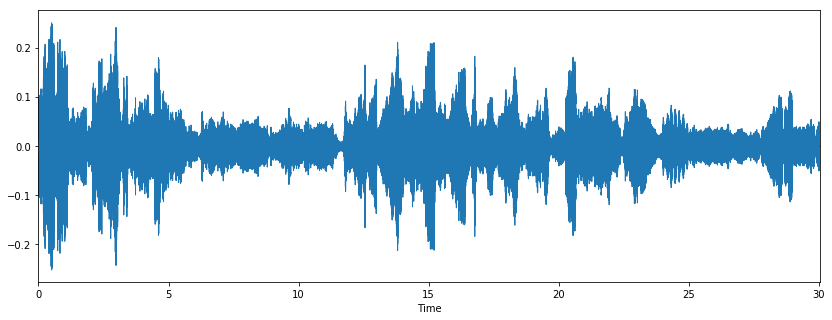

In [176]:
# plot waveform
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x_opera, sr_opera)

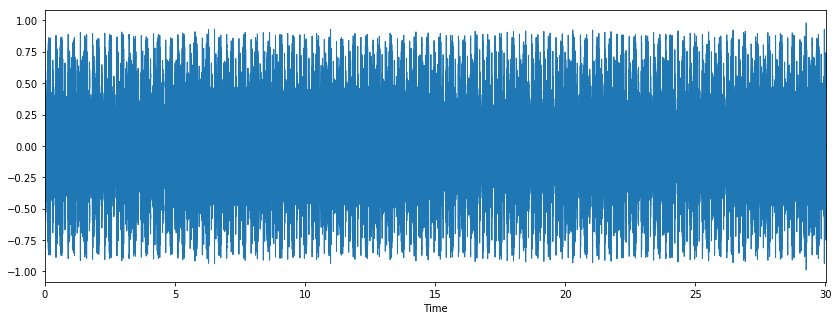

In [177]:
# plot waveform
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x_techno, sr_techno)

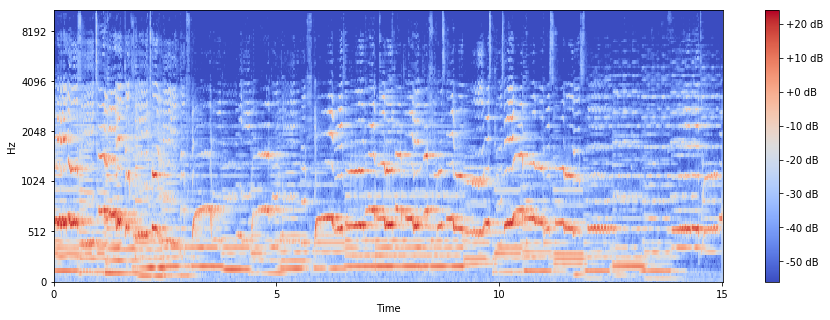

In [178]:
# compute power melspectrogram
S_opera = librosa.feature.melspectrogram(x_opera, sr=sr_opera, power=2.0)

# convert amplitude to decibels:
Sdb_opera = librosa.power_to_db(S_opera)

plt.figure(figsize=(15, 5))
librosa.display.specshow(Sdb_opera, sr=sr_opera, hop_length=256, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

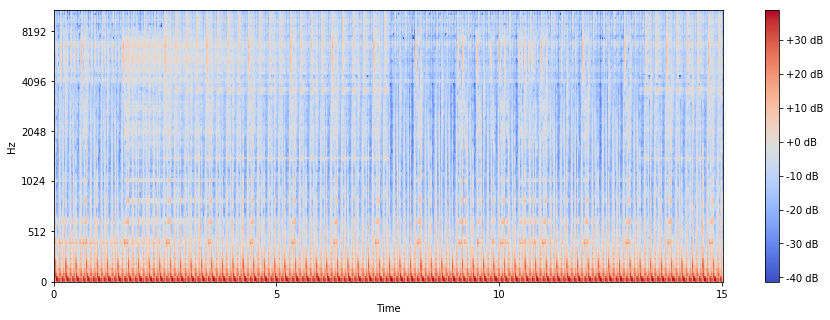

In [179]:
# compute power melspectrogram
S_techno = librosa.feature.melspectrogram(x_techno, sr=sr_techno, power=2.0)

# convert amplitude to decibels:
Sdb_techno = librosa.power_to_db(S_techno)

plt.figure(figsize=(15, 5))
librosa.display.specshow(Sdb_techno, sr=sr_techno, hop_length=256, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')# https://librosa.github.io/librosa/generated/librosa.core.power_to_db.html

/Users/cliffclive/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/cliffclive/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


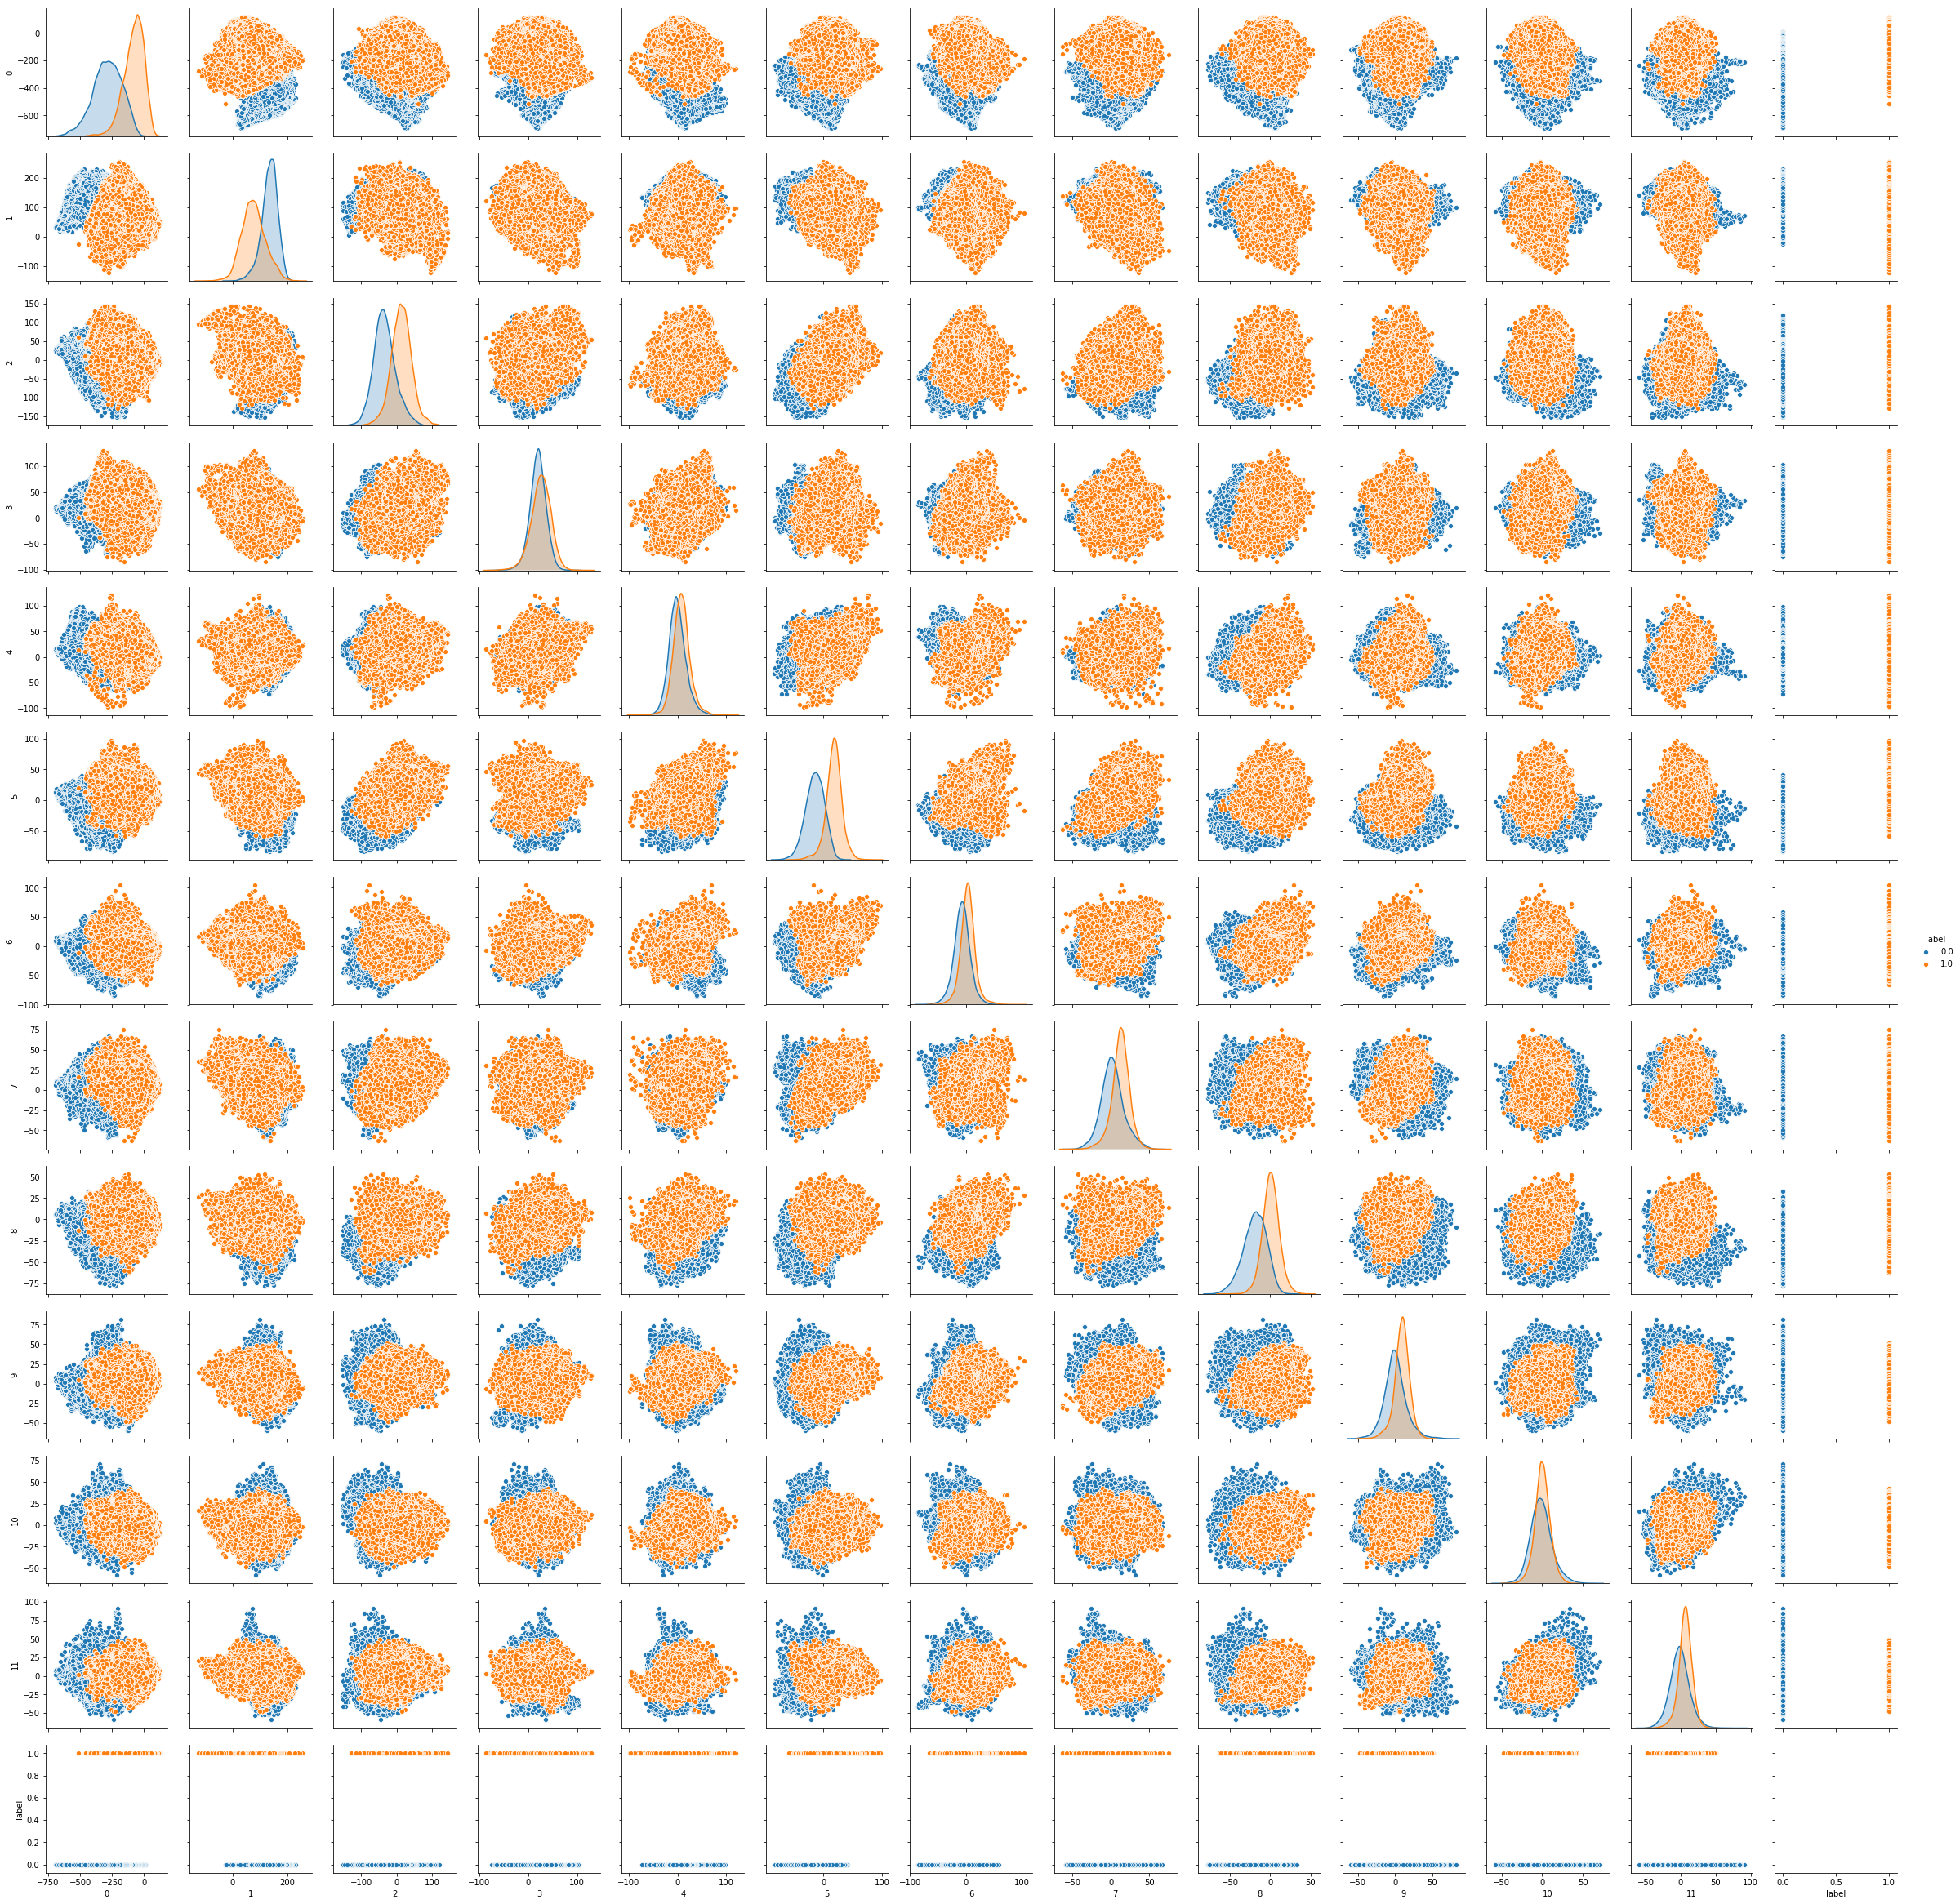

In [187]:
train_df = pd.DataFrame(X_train)
train_df['genre'] = pd.Series(y_train)

# Use pairplots to see if our features are separating our classes
# If none of these distributions look distinct, 
# we probably aren't ready to build a model.
sns.pairplot(train_df, hue='genre')

# Feature Engineering

In [75]:
print(x_opera.shape)
print(x_techno.shape)

(551250,)
(551250,)


In [51]:
# For each segment, compute the MFCCs. Experiment with n_mfcc 
# to select a different number of coefficients, e.g. 12.

n_mfcc = 12
mfcc_opera = librosa.feature.mfcc(x_opera, sr=sr_opera, n_mfcc=n_mfcc).T
mfcc_techno = librosa.feature.mfcc(x_techno, sr=sr_techno, n_mfcc=n_mfcc).T
print(mfcc_opera.shape)
print(mfcc_techno.shape)

(1077, 12)
(1077, 12)


In [52]:
# We transpose the result to accommodate scikit-learn 
# which assumes that each row is one observation, 
# and each column is one feature dimension:
print(mfcc_opera.mean(axis=0))
print(mfcc_techno.mean(axis=0))

[-3.22620413e+02  1.31981534e+02 -3.81426172e+01  1.59410647e+01
 -5.33753578e+00 -2.45646671e+01 -7.09567503e+00 -1.00411231e+01
 -2.08099488e+01  1.54900743e+00 -6.88379448e+00  1.29414016e-01]
[-70.5990494  110.07234127 -15.38447516  30.29360035  11.40980266
  13.1887302    4.16120848  14.70148311   6.93793432   2.36245179
  -1.74923723  10.802782  ]


In [53]:
print(mfcc_opera.std(axis=0))
print(mfcc_techno.std(axis=0))

[43.43314294 13.04729451 14.8868105  13.44975873 14.04579841 14.02652502
 13.72293445 12.61848589 13.16349114 15.68678663 13.19365754 17.30081689]
[75.77580306 35.01915211 25.51432721 13.6274698   8.36747809  9.38861117
  8.02683399  7.52577016  7.59602174  6.65214891  7.38966112  7.71826032]


In [76]:
# Scale the features to have zero mean and unit variance:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(np.concatenate((mfcc_opera, mfcc_techno), axis=0))

mfcc_opera_scaled = scaler.transform(mfcc_opera)

# Verify that the scaling worked:
mfcc_opera_scaled.mean(axis=0)

array([-0.89795083,  0.38295068, -0.47839005, -0.46832664, -0.5866079 ,
       -0.84522812, -0.44769849, -0.76579254, -0.79057356, -0.03373823,
       -0.23345577, -0.3700991 ])

In [77]:
# Scale the features to have zero mean and unit variance:
mfcc_techno_scaled = scaler.transform(mfcc_techno)

# Verify that the scaling worked:
mfcc_techno_scaled.mean(axis=0)

array([ 0.89795083, -0.38295068,  0.47839005,  0.46832664,  0.5866079 ,
        0.84522812,  0.44769849,  0.76579254,  0.79057356,  0.03373823,
        0.23345577,  0.3700991 ])

In [78]:
mfcc_opera_scaled.std(axis=0)

array([0.30950413, 0.45610721, 0.62585971, 0.87773763, 0.98396248,
       0.62805545, 1.09155204, 0.78109334, 0.75009023, 1.3012431 ,
       1.19976671, 1.19981186])

In [79]:
mfcc_techno_scaled.std(axis=0)

array([0.5399776 , 1.22419923, 1.0726535 , 0.88933513, 0.58617419,
       0.42038697, 0.63847182, 0.46585058, 0.43284123, 0.55180599,
       0.67197965, 0.53526145])

In [80]:
#Read the MFCC features from the first test audio excerpt into a data frame:
df_opera = pd.DataFrame(mfcc_opera_scaled)
df_opera.shape
df_opera.head()

0         1         2         3         4         5         6   \
0 -0.253808  1.006375  0.379843 -0.427861 -2.527825 -1.836969 -0.569770   
1 -0.327928  0.828770 -0.009244 -0.074555 -1.805895 -1.677987 -0.796038   
2 -0.486755  0.687197 -0.382191 -0.014137 -0.987683 -1.477975 -0.274523   
3 -0.467720  0.791338 -0.489927 -0.099143 -1.018384 -1.417075 -0.209405   
4 -0.472137  0.893622 -0.478557 -0.554136 -1.437468 -1.335898 -0.208223   

         7         8         9         10        11  
0  0.837488 -0.678173  1.136298  0.034786 -0.507111  
1  0.789644 -0.906153  1.530619 -0.601836 -0.221458  
2  0.255900 -1.151328  1.133997 -0.898657 -0.026570  
3  0.347857 -1.003723  1.225080 -0.932146 -0.362965  
4  0.481072 -0.927460  1.044785 -1.225651 -0.727554

In [81]:
# Compute the pairwise correlation of every pair of 12 MFCCs against one another for both test audio excerpts. For each audio excerpt, which pair of MFCCs are the most correlated? least correlated?
df_opera.corr()

0         1         2         3         4         5         6   \
0   1.000000  0.155341 -0.584078  0.475854 -0.283927 -0.124493 -0.076011   
1   0.155341  1.000000  0.059935  0.285242  0.256842  0.288806  0.226248   
2  -0.584078  0.059935  1.000000 -0.338654  0.067796  0.452856  0.113934   
3   0.475854  0.285242 -0.338654  1.000000  0.263330 -0.117194  0.005440   
4  -0.283927  0.256842  0.067796  0.263330  1.000000  0.187491 -0.363716   
5  -0.124493  0.288806  0.452856 -0.117194  0.187491  1.000000  0.328918   
6  -0.076011  0.226248  0.113934  0.005440 -0.363716  0.328918  1.000000   
7   0.221202 -0.161181  0.094880 -0.108459 -0.561911 -0.211930  0.174554   
8  -0.153929 -0.040330  0.228303 -0.233631 -0.043878 -0.070731 -0.462590   
9   0.030038 -0.516835 -0.147842 -0.251407 -0.274553 -0.631597 -0.419094   
10 -0.289863 -0.324328  0.086220 -0.260495  0.044231 -0.317557 -0.414403   
11 -0.034478 -0.322019 -0.016192 -0.216917  0.105577 -0.245415 -0.345103   

          7         8         9         10        11  
0   0.221202 -0.153929  0.030038 -0.289863 -0.034478  
1  -0.161181 -0.040330 -0.516835 -0.324328 -0.322019  
2   0.094880  0.228303 -0.147842  0.086220 -0.016192  
3  -0.108459 -0.233631 -0.251407 -0.260495 -0.216917  
4  -0.561911 -0.043878 -0.274553  0.044231  0.105577  
5  -0.211930 -0.070731 -0.631597 -0.317557 -0.245415  
6   0.174554 -0.462590 -0.419094 -0.414403 -0.345103  
7   1.000000  0.309354  0.214457 -0.238530 -0.265176  
8   0.309354  1.000000  0.361567  0.156282 -0.175709  
9   0.214457  0.361567  1.000000  0.570474  0.360384  
10 -0.238530  0.156282  0.570474  1.000000  0.656767  
11 -0.265176 -0.175709  0.360384  0.656767  1.000000

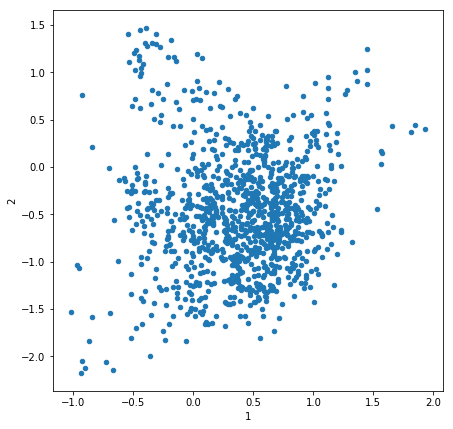

In [82]:
# Display a scatter plot of any two of the MFCC dimensions (i.e. columns of the data frame) against one another. Try for multiple pairs of MFCC dimensions.
df_opera.plot.scatter(1, 2, figsize=(7, 7))

# Train a Classifier

In [145]:
# do the train/test/split before reading in the features because 
# we will be collecting multiple observations per song, but we
# don't want songs to be included in both the train and test sets

def groupwise_train_test_split(groupdict, testsize=0.2):
    train_dict = {}
    test_dict = {}
    for group in groupdict.keys():
        splitter = int(len(groupdict[group]) * testsize)
        train = groupdict[group][splitter:]
        test = groupdict[group][:splitter]
        train_dict[group] = train
        test_dict[group] = test
    return train_dict, test_dict
    
train_genre_songpaths_dict, test_genre_songpaths_dict = groupwise_train_test_split(genre_songpaths_dict)

In [146]:
print(len(train_genre_songpaths_dict['opera']))
print(len(test_genre_songpaths_dict['opera']))
print(len(train_genre_songpaths_dict['techno']))
print(len(test_genre_songpaths_dict['techno']))

71
17
78
19


In [150]:
def get_mfcc_from_mp3(filepath, *args, **kwargs):
    x, sr = librosa.load(filepath)
    mfcc = librosa.feature.mfcc(x, sr, *args, **kwargs).T
    return mfcc

def collect_genre_mfccs(genre_songpaths_dict, n_mfcc=12):
    genre_mfccs = {}
    for genre in genre_songpaths_dict.keys():
        mfccs = [get_mfcc_from_mp3(x, n_mfcc=n_mfcc)
                 for x in genre_songpaths_dict[genre]]
        genre_mfccs[genre] = np.vstack(mfccs)
    return genre_mfccs

# THIS TAKES A WHILE, SO DON'T RE-RUN IT UNLESS THERE'S NEW DATA
# CODE IN THE FOLLOWING CELL READS SAVED FEATURES
#train_genre_features = collect_genre_mfccs(train_genre_songpaths_dict)
#test_genre_features = collect_genre_mfccs(test_genre_songpaths_dict)

In [153]:
#!mkdir ../data/interim/genre_mfccs
import pickle
'''
with open("../data/interim/genre_mfccs/train_genre_features.pkl", 'wb') as pkl:
    pickle.dump(train_genre_features, pkl)
with open("../data/interim/genre_mfccs/test_genre_features.pkl", 'wb') as pkl:
    pickle.dump(test_genre_features, pkl)
'''

with open("../data/interim/genre_mfccs/train_genre_features.pkl", 'rb') as pkl:
    train_genre_features = pickle.load(pkl)
with open("../data/interim/genre_mfccs/test_genre_features.pkl", 'rb') as pkl:
    test_genre_features = pickle.load(pkl)


In [159]:
X_train = np.vstack([train_genre_features['opera'],
                   train_genre_features['techno']])

y_train = np.concatenate(
    (np.zeros(train_genre_features['opera'].shape[0]), 
     np.ones(train_genre_features['techno'].shape[0])))

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit_transform(X_train)


array([[-1.32471209,  0.99905623,  0.27796023, ...,  0.38322017,
         0.52569547,  0.51708494],
       [-1.40698514,  0.88494401,  0.41138361, ...,  0.37853922,
         0.61907562,  0.46790977],
       [-1.50210883,  0.70631599,  0.51710918, ...,  0.30631359,
         0.62053319,  0.49079956],
       ...,
       [ 0.90776141, -0.56617639, -1.85978446, ..., -1.14881214,
        -0.05157618,  0.27423349],
       [ 0.73457021, -0.633333  , -1.6428691 , ..., -1.44775037,
        -0.42705509,  0.44786115],
       [-0.11054765, -0.67648673, -1.49435753, ..., -1.61692922,
        -0.4809014 ,  0.35001239]])

In [161]:
# Create a classifer model object:

# Support Vector Machine
model = sklearn.svm.SVC(gamma='scale')

# Train the classifier:
model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Test the Classifier

In [166]:
X_test = np.vstack([test_genre_features['opera'],
                   test_genre_features['techno']])

n_opera_tests = test_genre_features['opera'].shape[0]
n_techno_tests = test_genre_features['techno'].shape[0]

y_test = np.concatenate((np.zeros(n_opera_tests), np.ones(n_techno_tests)))

scaler.transform(X_test)

array([[-0.38257628,  0.95743068, -0.22351042, ...,  0.79832398,
        -0.31136689, -0.37688237],
       [-0.45626021,  0.85005038, -0.46426869, ...,  1.1510308 ,
        -0.9180583 , -0.05040841],
       [-0.61415224,  0.76445471, -0.69504045, ...,  0.79626547,
        -1.20092404,  0.172331  ],
       ...,
       [ 0.45743427,  0.03870273,  0.79160834, ...,  0.44069125,
         0.87848329,  0.94664556],
       [ 0.60152827,  0.11431978,  0.77503847, ...,  0.33651576,
         0.24536253,  0.69619686],
       [ 0.14948932,  0.07928547,  0.68483524, ...,  0.24387853,
        -0.14998606,  0.4673466 ]])

In [164]:
# Finally, compute the accuracy score of the classifier 
# on the test data:
score = model.score(X_test, y_test)
score

0.9738751502661858

In [165]:
X_test[:5,:]

array([[-2.32226945e+02,  1.49815053e+02, -1.77285433e+01,
         1.65611248e+01, -3.30478903e+01, -4.67134814e+01,
        -8.63035295e+00,  1.58597237e+01, -1.88374133e+01,
         1.56540658e+01, -3.93398107e+00, -1.84624022e+00],
       [-2.42628318e+02,  1.44734543e+02, -2.69834246e+01,
         2.19749163e+01, -2.27425269e+01, -4.31628885e+01,
        -1.14749774e+01,  1.50868011e+01, -2.28382685e+01,
         2.04076932e+01, -1.09348184e+01,  2.27275730e+00],
       [-2.64916680e+02,  1.40684735e+02, -3.58544186e+01,
         2.29007067e+01, -1.10627740e+01, -3.86959778e+01,
        -4.91852607e+00,  6.46421329e+00, -2.71408969e+01,
         1.56263221e+01, -1.41989112e+01,  5.08297562e+00],
       [-2.62245558e+02,  1.43663774e+02, -3.84170384e+01,
         2.15981420e+01, -1.15010205e+01, -3.73358669e+01,
        -4.09986361e+00,  7.94977309e+00, -2.45505537e+01,
         1.67243479e+01, -1.45671895e+01,  2.32281808e-01],
       [-2.62865429e+02,  1.46589667e+02, -3.8146580

In [167]:
# Calculate the accuracy of opera predictions
predicted_opera_labels = model.predict(X_test[:n_opera_tests,])
1 - predicted_opera_labels.mean()

0.9697245204109465

In [168]:
# Calculate the accuracy of techno predictions
predicted_techno_labels = model.predict(X_test[n_opera_tests:,])
predicted_techno_labels.mean()

0.9775888717156105

In [95]:
predicted_techno_labels

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])